# MCM complexes are barriers that restrict cohesin-mediated loop extrusion

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 3
+ S9

#### Archives:
+ Cohesin-MCM_wt_highsalt.yama
+ Cohesin-MCM_wt_lowsalt.yama
+ Cohesin-only_lowsalt.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji_MARS-beta18.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
import scipy.stats
import itertools
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci, significance
from tqdm.notebook import tqdm
from functools import reduce
from scipy.stats import norm
from pingouin import welch_anova, pairwise_gameshowell


marspy initialized.


### Select archives

In [3]:
selected_archives = ['Cohesin-MCM_wt_highsalt.yama',
                     'Cohesin-MCM_wt_lowsalt.yama',
                     'Cohesin-MCM_YDF_lowsalt.yama',
                     'Cohesin-only_lowsalt.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


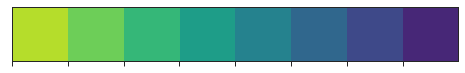

In [6]:
sns.palplot(palette)

In [7]:
# change to desired output directory
dir_out = '/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/no_statistics/'
dir_out

'/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/no_statistics/'

### Instantiate selected archives

In [8]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

MCM variant not found. Setting default to n/a



### Archives Overview

In [9]:
describe_archives(DnaMoleculeArchive.instances)


,# of datasets,# of molecules,labeled proteins,nucleotide,NaCl concentration,MCM variant,archive validation
Cohesin-MCM_wt_highsalt,12,106,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,500 mM,wt,passed
Cohesin-MCM_wt_lowsalt,20,180,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,150 mM,wt,passed
Cohesin-MCM_YDF_lowsalt,20,85,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,150 mM,ydf,passed
Cohesin-only_lowsalt,4,59,Halo-JF549-Cohesin,ATP,150 mM,n/a,passed


### Load segment tables, apply filter & detect pauses

In [10]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.detect_pauses(thresh=200, sigma_max=30, length=1)
    

### Add df_noidle to all molecules

In [11]:
for archive in tqdm(DnaMoleculeArchive.instances):
    
    archive.add_df_noidle(prefix='Cohesin_1_')

### Functions

In [12]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    """
    Calculates mean square displacement of molecules.
    Remove pairs with missing frames in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    *ignore_region: provide region name (regex) which is ignored for msd calculation (default False)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    """
    
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        #start=df[prefix+time_col].iloc[0]
        start=df[prefix+time_col].min()
        
    if np.isnan(end):
        #end=df[prefix+time_col].iloc[-1]
        end=df[prefix+time_col].max()
        
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
        try:
            # check if sliding window range
            if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):

                # check if we have consecutive frames (T) which are not null
                if (((df.loc[row+tau, prefix+'T'] - df.loc[row, prefix+'T']) == tau) and not
                    ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):

                    diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                    dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                else:
                    #skip to next row
                    continue

        # end of df
        except KeyError:
            break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

In [13]:
def calc_ars1_encounters(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object (dynamic treshold).
    """
    # defining dynamic tresholds based on DNA length
    # mean DNA length from analysis: 35.96 px
    mean_dna_length = 35.94
    _dna_length = molecule.calc_length_dna()
    thresh1 = mean_dna_length / _dna_length * 1500
    thresh2 = mean_dna_length / _dna_length * 500
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis = 0
    
    #passage events
    molecule.ars1_pass = 0
    
    #blocking events
    molecule.ars1_block = 0
    
    #time between consecutive passage events
    molecule.pass_times = []
       
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].median()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df_noidle.index:
        
        try:
            #direct collision
            if abs(molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < thresh1:
                  
                #passed
                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-thresh2 or 
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+thresh2):
                    
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_block+=1

            #no direct collision
            else:

                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-thresh2) or (
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+thresh2):
            
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff = np.diff(molecule.pass_times,n=1)

### Generate main df

In [14]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['lifetime', 'initial_intensity', 'msd', 'dtime', 'd_coeff']

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)

In [15]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()

Empty DataFrame
Columns: [(Cohesin_1_, d_coeff), (Cohesin_1_, dtime), (Cohesin_1_, initial_intensity), (Cohesin_1_, lifetime), (Cohesin_1_, msd), (MCM_1_, d_coeff), (MCM_1_, dtime), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, msd)]
Index: []

In [16]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'nacl'] = archive.nacl
        
        # assign MCM variant and change to n/a for molecules without MCM on DNA
        try:
            if molecule.proteins['MCM'] > 0:
                df.loc[molecule.uid,'MCM_variant'] = archive.mcm
            else:
                df.loc[molecule.uid,'MCM_variant'] = 'n/a'
        except KeyError:
            # archive has 'n/a' by default
            df.loc[molecule.uid,'MCM_variant'] = archive.mcm
        
        try:
            df.loc[molecule.uid,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
        except KeyError:
            pass
        
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        
        # calculate encounters between Cohesin and ARS1 here
        calc_ars1_encounters(molecule)
        df.loc[molecule.uid,'Visualized encounters'] = molecule.ars1_encounters_vis
        df.loc[molecule.uid,'ARS1 pass'] = molecule.ars1_pass
        df.loc[molecule.uid,'ARS1 block'] = molecule.ars1_block
        
        if ((molecule.ars1_pass + molecule.ars1_block) != molecule.ars1_encounters_vis):
            print(molecule.uid,'NO MATCH UP IN COLLISIONS BEFORE PAUSE')
        
        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #observation time (in s) defined by tracking length
            df.loc[molecule.uid,(prefix,'timespan_(s)')] = molecule.df.filter(regex=prefix).dropna()[prefix+'Time_(s)'].max()
            
            # average position on DNA (try mean but might switch to median due to noise)
            df.loc[molecule.uid,(prefix,'avg_position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].median()
            
            # MSD (kbp^2) & dtime (s)    
            msd, dtime = calc_msd(df=molecule.df_noidle, prefix=prefix, msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)
            df.loc[molecule.uid,(prefix,'msd')] = msd/(1000**2)
            df.loc[molecule.uid,(prefix,'dtime')] = dtime

            # diffusion coefficient (kbp^2/s)
            df.loc[molecule.uid,(prefix,'d_coeff')] = df.loc[molecule.uid,(prefix,'msd')] / (2*df.loc[molecule.uid,(prefix,'dtime')])
            
            # pauses:
            # number of pauses
                        
            for seg_df in filter(lambda sdf: sdf.type == 'rate' and sdf.prefix == prefix, molecule.seg_dfs):
                df.loc[molecule.uid,(prefix,'number_pauses')] = len(seg_df.df[seg_df.df['pause_B']])
                
                # count each pause as one encounter which was blocked
                df.loc[molecule.uid,'Visualized encounters'] =  df.loc[molecule.uid,'Visualized encounters'].item() + len(seg_df.df[seg_df.df['pause_B']])
                df.loc[molecule.uid,'ARS1 block'] = df.loc[molecule.uid,'ARS1 block'].item() + len(seg_df.df[seg_df.df['pause_B']])
            
                # cumulative pause duration
                df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] = (seg_df.df[seg_df.df['pause_B']]['X2'] - seg_df.df[seg_df.df['pause_B']]['X1']).sum()
                   
                # fraction of trajectory protein being idle
                df.loc[molecule.uid,(prefix,'fraction_idle')] = (df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] /
                                                                 df.loc[molecule.uid,(prefix,'timespan_(s)')])
            
            if (df.loc[molecule.uid,'Visualized encounters'].item() !=  (df.loc[molecule.uid,'ARS1 block'].item() + df.loc[molecule.uid,'ARS1 pass'].item())):
                print(molecule.uid,'NO MATCH UP IN COLLISIONS AFTER PAUSE')
                
        
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# replace NaN values for number_MCM with 0, then rename and convert to boolean
df['number_MCM'] = df['number_MCM'].apply(lambda value: 0 if np.isnan(value) else value)
df['MCM_at_origin'] = df['number_MCM'].apply(lambda value: value>=1)

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
df

molecule               ARS1 block ARS1 pass          Cohesin_1_  \
properties                                  avg_position_on_dna   
2PFd8LrNDti9JB4QSh3mR9       51.0      30.0        10943.180951   
2QGskSzFLzrBr7YLN78knZ       80.0     153.0        11104.290270   
2Z4r51hJSvdkiVDjjqKUrj      113.0      55.0         6400.457100   
2sTgZedaFFf9CK5b3GF6Cn       14.0      24.0        13552.669057   
3AoBkpRczab2PADB4kryfY      131.0       4.0        11786.407599   
...                           ...       ...                 ...   
uD2qeX3fcDrkHLrEykKP3x       87.0      87.0        11812.807235   
uwCQQd5mMKFh5gQwnP9b3p      123.0     110.0        10979.640516   
vbQbfgRcaVUyxLdweJ2Y7p       39.0      25.0         9983.075330   
xcfK4nJ1oobZtYbMGVJHYQ      103.0      14.0        14092.327353   
xtREv4R9FAjgZ88vrbJPJM       65.0      61.0         9569.537131   

molecule                                                            \
properties             cum_pause_duration_(s)    d_coeff     dtime   
2PFd8LrNDti9JB4QSh3mR9                    0.0  19.546419  0.187930   
2QGskSzFLzrBr7YLN78knZ                    0.0  29.767491  0.182752   
2Z4r51hJSvdkiVDjjqKUrj                    0.0  43.310971  0.183297   
2sTgZedaFFf9CK5b3GF6Cn                    0.0  52.460617  0.184878   
3AoBkpRczab2PADB4kryfY                    0.0  23.531469  0.184084   
...                                       ...        ...       ...   
uD2qeX3fcDrkHLrEykKP3x                    0.0  19.707632  0.185782   
uwCQQd5mMKFh5gQwnP9b3p                    0.0  22.283112  0.186097   
vbQbfgRcaVUyxLdweJ2Y7p                    0.0  11.486890  0.185274   
xcfK4nJ1oobZtYbMGVJHYQ                    0.0   3.351588  0.185053   
xtREv4R9FAjgZ88vrbJPJM                    0.0  18.089110  0.186255   

molecule                                                                    \
properties             fraction_idle initial_intensity lifetime        msd   
2PFd8LrNDti9JB4QSh3mR9           0.0           86644.6      NaN   7.346713   
2QGskSzFLzrBr7YLN78knZ           0.0           29989.5      NaN  10.880131   
2Z4r51hJSvdkiVDjjqKUrj           0.0           19703.6      NaN  15.877540   
2sTgZedaFFf9CK5b3GF6Cn           0.0            9802.7      NaN  19.397633   
3AoBkpRczab2PADB4kryfY           0.0           33791.1      NaN   8.663536   
...                              ...               ...      ...        ...   
uD2qeX3fcDrkHLrEykKP3x           0.0           24928.3      NaN   7.322659   
uwCQQd5mMKFh5gQwnP9b3p           0.0           42789.6      NaN   8.293621   
vbQbfgRcaVUyxLdweJ2Y7p           0.0           11532.8      NaN   4.256441   
xcfK4nJ1oobZtYbMGVJHYQ           0.0           12821.3      NaN   1.240442   
xtREv4R9FAjgZ88vrbJPJM           0.0           23820.3      NaN   6.738368   

molecule                ... MCM_variant Visualized encounters dna_length  \
properties              ...                                                
2PFd8LrNDti9JB4QSh3mR9  ...          wt                  81.0  38.988975   
2QGskSzFLzrBr7YLN78knZ  ...         n/a                 233.0  43.426647   
2Z4r51hJSvdkiVDjjqKUrj  ...          wt                 168.0  36.079005   
2sTgZedaFFf9CK5b3GF6Cn  ...         n/a                  38.0  31.864820   
3AoBkpRczab2PADB4kryfY  ...          wt                 135.0  42.316194   
...                     ...         ...                   ...        ...   
uD2qeX3fcDrkHLrEykKP3x  ...         n/a                 174.0  37.013511   
uwCQQd5mMKFh5gQwnP9b3p  ...         n/a                 233.0  35.057096   
vbQbfgRcaVUyxLdweJ2Y7p  ...         n/a                  64.0  36.667045   
xcfK4nJ1oobZtYbMGVJHYQ  ...         n/a                 117.0  31.016125   
xtREv4R9FAjgZ88vrbJPJM  ...         n/a                 126.0  36.013886   

molecule               label_Cohesin   label_MCM    nacl nucleotide  \
properties                                                            
2PFd8LrNDti9JB4QSh3mR9    Halo-JF549  ybbR-LD655  500 mM        ATP   


In [18]:
df['ARS1 passing probability'] = df['ARS1 pass'] / df['Visualized encounters']


In [19]:
# df with all molecules removed with 0 visualized encounters
df2 = df.copy()

df2 = df2[(df2['Visualized encounters']!=0)]

## setup df_pause

In [20]:
df_pause = pd.DataFrame(columns=['MCM_at_origin', 'MCM_bleaching_steps', 'MCM_variant', 'nacl', 
                                 'pause_duration','MCM_position_on_dna', 'pause_position_on_dna', 'pause_at_MCM', 'Cohesin_turnaround'])   
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_variant,nacl,pause_duration,MCM_position_on_dna,pause_position_on_dna,pause_at_MCM,Cohesin_turnaround


In [21]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        
        # defining dynamic tresholds based on DNA length
        # mean DNA length from analysis: 35.95 px
        mean_dna_length = 35.95
        _dna_length = molecule.calc_length_dna()
        thresh1 = mean_dna_length / _dna_length * 1500
        thresh2 = mean_dna_length / _dna_length * 500
        
        
        #get number of theoretical encounters with ARS1 from cohesin only molecules
        try:
            if molecule.proteins['MCM'] > 0:
                pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].median()
            else:
                pos_ars1 = 5557.5
        except KeyError:
            pos_ars1 = 5557.5

        # pauses:
        for seg_df in filter(lambda sdf: sdf.type == 'rate' and sdf.prefix == 'Cohesin_1_', molecule.seg_dfs):
            for row, index in seg_df.df[seg_df.df['pause_B']].iterrows():
                pause_start = seg_df.df[seg_df.df['pause_B']].loc[row, 'X1']
                pause_end = seg_df.df[seg_df.df['pause_B']].loc[row, 'X2']
                # temporary df
                _temp_df = pd.DataFrame()
                try:
                    _temp_df.loc[0,'MCM_at_origin'] = molecule.proteins['MCM'] > 0
                    _temp_df.loc[0,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
                    _temp_df.loc[0,'MCM_variant'] = archive.mcm
                    _temp_df.loc[0,'MCM_position_on_dna'] = molecule.df['MCM_1_Position_on_DNA'].median()
                except KeyError:
                    _temp_df.loc[0,'MCM_at_origin'] = False
                    _temp_df.loc[0,'MCM_variant'] = 'n/a'

                _temp_df.loc[0,'nacl'] = archive.nacl
                _temp_df.loc[0,'pause_duration'] = pause_end - pause_start

                _temp_df.loc[0,'pause_position_on_dna'] = molecule.df[(molecule.df[seg_df.prefix+seg_df.col_x] >= pause_start) & 
                                                                (molecule.df[seg_df.prefix+seg_df.col_x] <= pause_end)]['Cohesin_1_Position_on_DNA'].median()

                try:
                    # before and after pause frames higher DNA position
                    if ((molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item()-1,'Cohesin_1_Position_on_DNA'] > 
                         molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA']) and
                        (molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA'] > 
                         molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item(),'Cohesin_1_Position_on_DNA'])):

                        _temp_df.loc[0,'Cohesin_turnaround'] = True

                    # before and after pause frames lower DNA position
                    elif ((molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item()-1,'Cohesin_1_Position_on_DNA'] < 
                         molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA']) and
                        (molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA'] < 
                         molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item(),'Cohesin_1_Position_on_DNA'])):
                          _temp_df.loc[0,'Cohesin_turnaround'] = True

                    else:
                          _temp_df.loc[0,'Cohesin_turnaround'] = False
                
                # pause starting from first frame
                except KeyError:
                    pass
                

                try:
                    #pause happened in origin range
                    if abs(molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA'] - pos_ars1) < thresh1:

                        #passed
                        if ((molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA'] < 
                             pos_ars1 < 
                             molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA']-thresh2) 
                            or 
                            (molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA'] > 
                             pos_ars1 > 
                             molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA']+thresh2)):
                            
                            _temp_df.loc[0,'Cohesin_pause_pass'] = True

                        #blocked
                        else:
                            _temp_df.loc[0,'Cohesin_pause_pass'] = False

                    #no direct collision
                    else:

                        if ((molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA'] < 
                             pos_ars1 < 
                             molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA']-thresh2) 
                            or 
                            (molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_start].item(),'Cohesin_1_Position_on_DNA'] > 
                             pos_ars1 > 
                             molecule.df.loc[molecule.df.index[molecule.df['Cohesin_1_Time_(s)'] == pause_end].item()+1,'Cohesin_1_Position_on_DNA']+thresh2)):

                            _temp_df.loc[0,'Cohesin_pause_pass'] = True

                except KeyError:
                    #print('last row reached, skip.')
                    pass


                try:
                    _temp_df.loc[0,'pause_at_MCM'] = abs(molecule.df['MCM_1_Position_on_DNA'].median() - _temp_df.loc[0,'pause_position_on_dna']) <= thresh1
                except KeyError:
                    pass

                df_pause = pd.concat([df_pause, _temp_df])
            
# again sort MultiIndexCols for performance
df_pause.sort_index(axis=1, inplace=True)

# fix data types
df_pause = df_pause.infer_objects()

In [22]:
df_pause.head()

,Cohesin_pause_pass,Cohesin_turnaround,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,NaN,False,True,3.0,3536.266783,wt,500 mM,False,52.69,20174.329127
0,False,NaN,True,2.0,5899.103012,wt,500 mM,True,6.46,6464.073379
0,False,True,True,2.0,5107.475979,wt,500 mM,True,3.45,4931.523516
0,False,False,True,2.0,5107.475979,wt,500 mM,True,182.28,4840.273699
0,False,True,True,2.0,5273.016721,wt,150 mM,True,35.80,4888.595960


## EDA

/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


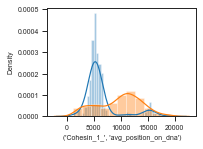

In [23]:
# where does cohesin accumulate in regard to MCM positions
sns.distplot(df[('MCM_1_','avg_position_on_dna')])
sns.distplot(df[('Cohesin_1_','avg_position_on_dna')])

In [24]:
# overview of barrier function calculated by 3 different methods
df2.groupby(['nacl','number_MCM']).describe().filter(regex='ARS1 passing probability')

molecule          ARS1 passing probability                                \
properties                                                                 
                                     count      mean       std       min   
nacl   number_MCM                                                          
150 mM 0.0                            74.0  0.369155  0.144901  0.000000   
       1.0                           241.0  0.078943  0.116229  0.000000   
500 mM 0.0                            40.0  0.574977  0.143807  0.127072   
       1.0                            64.0  0.225951  0.211485  0.000000   

molecule                                                   
properties                                                 
                        25%       50%       75%       max  
nacl   number_MCM                                          
150 mM 0.0         0.286136  0.377633  0.481121  0.666667  
       1.0         0.000000  0.028571  0.116438  0.681818  
500 mM 0.0         0.563065  0.616200  0.656919  0.801527  
       1.0         0.011376  0.214411  0.408221  0.730594

In [25]:
df2.head()

molecule               ARS1 block ARS1 pass          Cohesin_1_  \
properties                                  avg_position_on_dna   
2PFd8LrNDti9JB4QSh3mR9       51.0      30.0        10943.180951   
2QGskSzFLzrBr7YLN78knZ       80.0     153.0        11104.290270   
2Z4r51hJSvdkiVDjjqKUrj      113.0      55.0         6400.457100   
2sTgZedaFFf9CK5b3GF6Cn       14.0      24.0        13552.669057   
3AoBkpRczab2PADB4kryfY      131.0       4.0        11786.407599   

molecule                                                            \
properties             cum_pause_duration_(s)    d_coeff     dtime   
2PFd8LrNDti9JB4QSh3mR9                    0.0  19.546419  0.187930   
2QGskSzFLzrBr7YLN78knZ                    0.0  29.767491  0.182752   
2Z4r51hJSvdkiVDjjqKUrj                    0.0  43.310971  0.183297   
2sTgZedaFFf9CK5b3GF6Cn                    0.0  52.460617  0.184878   
3AoBkpRczab2PADB4kryfY                    0.0  23.531469  0.184084   

molecule                                                                    \
properties             fraction_idle initial_intensity lifetime        msd   
2PFd8LrNDti9JB4QSh3mR9           0.0           86644.6      NaN   7.346713   
2QGskSzFLzrBr7YLN78knZ           0.0           29989.5      NaN  10.880131   
2Z4r51hJSvdkiVDjjqKUrj           0.0           19703.6      NaN  15.877540   
2sTgZedaFFf9CK5b3GF6Cn           0.0            9802.7      NaN  19.397633   
3AoBkpRczab2PADB4kryfY           0.0           33791.1      NaN   8.663536   

molecule                ... Visualized encounters dna_length label_Cohesin  \
properties              ...                                                  
2PFd8LrNDti9JB4QSh3mR9  ...                  81.0  38.988975    Halo-JF549   
2QGskSzFLzrBr7YLN78knZ  ...                 233.0  43.426647    Halo-JF549   
2Z4r51hJSvdkiVDjjqKUrj  ...                 168.0  36.079005    Halo-JF549   
2sTgZedaFFf9CK5b3GF6Cn  ...                  38.0  31.864820    Halo-JF549   
3AoBkpRczab2PADB4kryfY  ...                 135.0  42.316194    Halo-JF549   

molecule                 label_MCM    nacl nucleotide number_Cohesin  \
properties                                                             
2PFd8LrNDti9JB4QSh3mR9  ybbR-LD655  500 mM        ATP            1.0   
2QGskSzFLzrBr7YLN78knZ  ybbR-LD655  500 mM        ATP            1.0   
2Z4r51hJSvdkiVDjjqKUrj  ybbR-LD655  500 mM        ATP            1.0   
2sTgZedaFFf9CK5b3GF6Cn  ybbR-LD655  500 mM        ATP            1.0   
3AoBkpRczab2PADB4kryfY  ybbR-LD655  500 mM        ATP            1.0   

molecule               number_MCM               tags ARS1 passing probability  
properties                                                                     
2PFd8LrNDti9JB4QSh3mR9        1.0           [accept]                 0.370370  
2QGskSzFLzrBr7YLN78knZ        0.0           [accept]                 0.656652  
2Z4r51hJSvdkiVDjjqKUrj        1.0           [accept]                 0.327381  
2sTgZedaFFf9CK5b3GF6Cn        0.0           [accept]                 0.631579  
3AoBkpRczab2PADB4kryfY        1.0  [accept, perfect]                 0.029630  

[5 rows x 32 columns]

## Figures

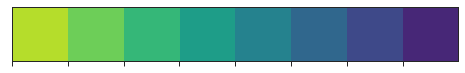

In [26]:
sns.palplot(palette)

### Example MCM bleaching trajectories

In [27]:
example_molecules = ['bfhq3KJhprt6Uk9xqN2RVw', 'qf26JqfJC5CXLBifQZa1MZ','3T4CJeXAeAJusyfK3Co8B6','x2yJf3Rz9b4VZHFeJhm2F2'
                     , 'ctWAySLeuyw2muGU2mM3vG', 'o5DmPxZvHpJSh87zn5f68s']

In [28]:
molecule.df

,Cohesin_1_T,Cohesin_1_X,Cohesin_1_Y,Cohesin_1_Intensity,Cohesin_1_Time_(s),Cohesin_1_Position_on_DNA
0,0.0,409.859815,618.074202,19080.0,0.00,6828.157910
1,1.0,409.476282,621.633155,26490.5,0.20,8923.448815
2,2.0,410.454432,619.183776,12485.5,0.38,7500.278350
3,3.0,410.063675,612.434696,27021.0,0.56,3515.210319
4,4.0,410.265915,611.178974,34024.5,0.73,2795.730414
...,...,...,...,...,...,...
532,554.0,413.331438,615.766399,2722.0,103.12,5912.692385
533,555.0,409.880804,623.348592,4367.0,103.31,9937.502464
534,557.0,409.487930,618.657008,4009.0,103.69,7168.522204
535,558.0,410.400466,617.655184,4053.5,103.87,6599.177368


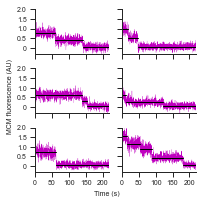

In [29]:
# 2 step photobleaching MCM example molecule: ySey5qnA9nZEdm66fh6Ku
rows = 3
cols = 2

fig,axes=plt.subplots(rows,cols,figsize=(3,3),sharex=True, sharey=True)

row_counter = 0
col_counter = 0

for uid in example_molecules:
    molecule = DnaMoleculeArchive.instances[0].get_molecule_by_uid(uid)
    sns.lineplot(x='MCM_1_Time_(s)', y='MCM_1_Intensity',data=molecule.df,
                 ax=axes[row_counter,col_counter],color='m',lw=0.25)
    for seg_df in filter(lambda sdf: sdf.type == 'bleaching', molecule.seg_dfs):
        for row in seg_df.df.index:
            temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['X1','Y1']].values, seg_df.df.loc[row,['X2','Y2']].values],columns=['X','Y'])
            sns.lineplot(x='X', y='Y',data=temp_df,ax=axes[row_counter,col_counter],color='k',lw=1)

        if col_counter < cols-1:
            col_counter+=1
        else:
            row_counter+=1
            col_counter=0
        
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'MCM fluorescence (AU)', va='center', rotation='vertical')
        
for ax_array in axes:
    for ax in ax_array:
        ax.set_xlabel(None)
        ax.set_ylabel(None)


plt.xticks([0,50,100,150,200])
plt.yticks([0,5000,10000,15000,20000])
axes[0,0].set_yticklabels([0,0.5,1.0,1.5,2.0])
plt.xlim(0,220)
plt.ylim([-3000,20000])
#plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
#fig.suptitle('Photobleaching confirms MCM DH formation')

sns.despine()

fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.savefig(dir_out+"MCM_DH_bleaching.svg",transparent=True)

### 1 - Cohesin diffusion coefficient (pause segments and YDF data excluded)

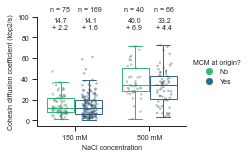

In [30]:
fig,axes = plt.subplots()
data = df[df['MCM_variant'] != 'ydf']
#setup style

boxprops = {'edgecolor': '.15', 'linewidth': 1, 'facecolor':'w'}
lineprops = {'color': '.15', 'linewidth': 1}
kwargs = {'hue_order': [False, True]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=data, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, palette=palette[2::3], **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=data, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.2, palette=palette[2::3], **stripplot_kwargs)

axes.set_xlim(-0.5,1.5)
axes.set_ylim(-5,100)
axes.set_xlabel('NaCl concentration')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')

#calculate number of observations
nobs = data.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and 95 % ci by bootstrapping (more accurate than 1.96xsem)

bootstrap_mean = []
bootstrap_95_ci_lower = []
bootstrap_95_ci_upper = []

for nacl in data['nacl'].sort_values().unique():
    for ori_mcm in data['MCM_at_origin'].sort_values().unique():       
        bootstrap_data = data[(data['nacl'] == nacl) & (data['MCM_at_origin']==ori_mcm)][('Cohesin_1_','d_coeff')]
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        bootstrap_mean.append(np.mean(bootstrap_means))
        ci_lower, ci_upper = calc_ci(bootstrap_means,ci=95)
        bootstrap_95_ci_lower.append(ci_lower)
        bootstrap_95_ci_upper.append(ci_upper)

bootstrap_mean = [round(num,1) for num in bootstrap_mean]
ci_95_range = [(bootstrap_95_ci_upper[i] - bootstrap_95_ci_lower[i])/2 for i in range(len(bootstrap_95_ci_upper))]
ci_95_range = [round(num,1) for num in ci_95_range]

diffusion = [f'{bootstrap_mean[i]}\n+ {ci_95_range[i]}' for i in range(len(bootstrap_mean))]

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 110, nobs[ind], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick+.2, 110, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick-.2, 100, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick+.2, 100, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='.15')
    ind += 2

# alpha for boxplot filling (not required here)
for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = palette[2]
    else:
        col = palette[5]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        
# Fix the legend, keep only the first two legend elements
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles[2:], ['No', 'Yes'], frameon=False, title='MCM at origin?',
               loc='center left', bbox_to_anchor=[1, 0.5],handletextpad=0.5)

lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]


sns.despine()

plt.savefig(dir_out+'Cohesin_diffusion_coefficient.svg',transparent=True)

### 2 - MCM barrier for cohesin translocation

### a - 150 mM NaCl 

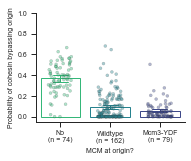

In [31]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])
     
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM.svg',transparent=True)

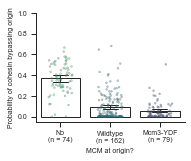

In [374]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': '.15', 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])
     
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_v2.svg',transparent=True)

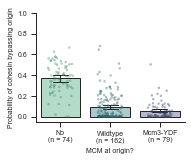

In [375]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': '.15', 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])
     
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_v3.svg',transparent=True)

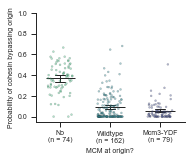

In [380]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': '.15', 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.2, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

# plot 95 % ci
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            markers='', **barplot_kwargs, join=False, color='.15')
# plot mean
means = data.groupby('MCM_variant')['ARS1 passing probability'].mean().values
plt.errorbar(range(0,3), means, xerr=0.3, fmt='none', ecolor='.15', elinewidth=1)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])
     
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_v4.svg',transparent=True)

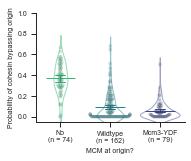

In [357]:
# as violinplot
fig,axes = plt.subplots(figsize=(17,2))
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

vioprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0), 
            'errwidth':1, 'capsize':.2, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

vioplot_kwargs = dict(vioprops, **kwargs)

swarmplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.2},
                        **kwargs)

sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=None, **vioplot_kwargs, color='w', inner=None)

# change edgelinecolor
for i in range(3):
    
    axes.collections[i].set_edgecolor(palette[2+i*2])
    axes.collections[i].set_alpha(0.5)

sns.swarmplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, palette=palette[2::2], **swarmplot_kwargs)
# plot 95 % ci
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], markers='', **vioplot_kwargs)
# plot mean
means = data.groupby('MCM_variant')['ARS1 passing probability'].mean().values
plt.errorbar(range(0,3), means, xerr=0.3, fmt='none', ecolor=palette[2::2], elinewidth=1)


axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')


#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])

fig.set_size_inches(2.67,2)   
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_violin.svg',transparent=True)

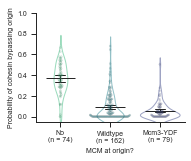

In [358]:
# as violinplot
fig,axes = plt.subplots(figsize=(12,2))
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

vioprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0), 
            'errwidth':1, 'capsize':.2, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

vioplot_kwargs = dict(vioprops, **kwargs)

swarmplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.2},
                        **kwargs)

sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=None, **vioplot_kwargs, color='w', inner=None)

# change edgelinecolor
for i in range(3):
    
    axes.collections[i].set_edgecolor(palette[2+i*2])
    axes.collections[i].set_alpha(0.5)

sns.swarmplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, palette=palette[2::2], **swarmplot_kwargs)
# plot 95 % ci
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            markers='', **vioplot_kwargs, join=False, color='.15')
# plot mean
means = data.groupby('MCM_variant')['ARS1 passing probability'].mean().values
plt.errorbar(range(0,3), means, xerr=0.3, fmt='none', ecolor='.15', elinewidth=1)


axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')


#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])

fig.set_size_inches(2.67,2)   
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_violin-v2.svg',transparent=True)

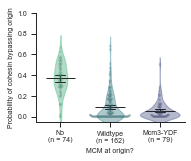

In [359]:
# as violinplot
fig,axes = plt.subplots(figsize=(12,2))
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

vioprops = {'edgecolor': palette[2::2], 'linewidth': 1, 
            'errwidth':1, 'capsize':.2, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

vioplot_kwargs = dict(vioprops, **kwargs)

swarmplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.2},
                        **kwargs)

sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,palette=palette[2::2],
             **vioplot_kwargs, inner=None)

# change edgelinecolor
for i in range(3):
    
    axes.collections[i].set_edgecolor(palette[2+i*2])
    axes.collections[i].set_alpha(0.4)

sns.swarmplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, palette=palette[2::2], **swarmplot_kwargs)
# plot 95 % ci
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            markers='', **vioplot_kwargs, join=False, color='.15')
# plot mean
means = data.groupby('MCM_variant')['ARS1 passing probability'].mean().values
plt.errorbar(range(0,3), means, xerr=0.3, fmt='none', ecolor='.15', elinewidth=1)


axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')


#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])

fig.set_size_inches(2.67,2)   
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_violin-v3.svg',transparent=True)

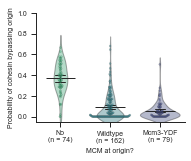

In [365]:
# as violinplot
fig,axes = plt.subplots(figsize=(12,2))
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

vioprops = {'edgecolor': palette[2::2], 'linewidth': 1, 
            'errwidth':1, 'capsize':.2, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

vioplot_kwargs = dict(vioprops, **kwargs)

swarmplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,palette=palette[2::2],
             **vioplot_kwargs, inner=None)

# change edgelinecolor
for i in range(3):
    
    axes.collections[i].set_edgecolor('.15')
    axes.collections[i].set_alpha(0.4)

sns.swarmplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, palette=palette[2::2], **swarmplot_kwargs)
# plot 95 % ci
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            markers='', **vioplot_kwargs, join=False, color='.15')
# plot mean
means = data.groupby('MCM_variant')['ARS1 passing probability'].mean().values
plt.errorbar(range(0,3), means, xerr=0.3, fmt='none', ecolor='.15', elinewidth=1)


axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')


#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])

fig.set_size_inches(2.67,2)   
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_violin-v4.svg',transparent=True)

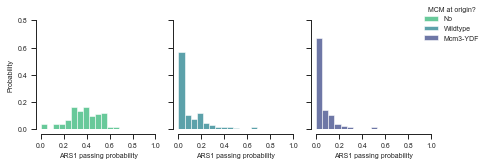

In [32]:
fig,axes = plt.subplots(1,3,figsize=(7,2), sharey=True)
sns.histplot(data=data[data['MCM_variant']=='n/a'], x='ARS1 passing probability', bins=np.linspace(0,1,20), stat='probability',
            color=palette[2],ax=axes[0], label='No')
sns.histplot(data=data[data['MCM_variant']=='wt'], x='ARS1 passing probability', bins=np.linspace(0,1,20), stat='probability',
            color=palette[4],ax=axes[1], label='Wildtype')
sns.histplot(data=data[data['MCM_variant']=='ydf'], x='ARS1 passing probability', bins=np.linspace(0,1,20), stat='probability',
            color=palette[6],ax=axes[2], label='Mcm3-YDF')

axes[0].set_ylim(0,0.8)
for ax in axes:
    ax.set_xlim(0,1)
fig.legend(frameon=False, title='MCM at origin?')
sns.despine(offset=5)

plt.savefig(dir_out+'Cohesin_origin_bypass_DistProblem.svg',transparent=True)

### b - 500 mM NaCl

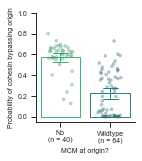

In [33]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 1.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})'])
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_500mM.svg',transparent=True)


### Check DNA length distribution

/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


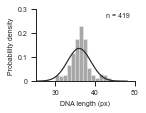

In [34]:
fig,axes = plt.subplots(figsize=(1.78,1.33))

data = df2

sns.distplot(data['dna_length'], bins=np.linspace(25,50,26), kde=False, fit=norm, color='.15', norm_hist=True)

axes.set_xlim(25,50)
axes.set_ylim(0, 0.25)
axes.set_yticks([0,0.1,0.2,0.3])
axes.set_yticklabels([0,0.1,0.2,0.3])
axes.set_xlabel('DNA length (px)')
axes.set_ylabel('Probability density')
 
axes.text(0.95, 0.95, f"n = {len(data['dna_length'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()

plt.savefig(dir_out+'DNA_lengths.svg',transparent=True)

In [35]:
df2['dna_length'].mean()

35.95095122438912

### 3 - MCM barrier for cohesin translocation vs #MCM

### a - 150 mM NaCl - wildtype MCM

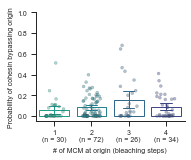

In [36]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.05,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ['n = ' + i for i in nobs]

#put nobs into plot together with xlabel
#get current xticklabels
labels = [label.get_text() for label in axes.get_xticklabels()]
#merge labels with nobs
for i in range(len(labels)):
    labels[i] = labels[i]+'\n('+nobs[i]+')'
axes.set_xticklabels(labels)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_150mM.svg',transparent=True)

### b - 150 mM NaCl - YDF MCM

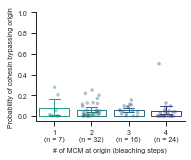

In [37]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'ydf')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.05,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
#get current xticklabels
labels = [label.get_text() for label in axes.get_xticklabels()]
#merge labels with nobs
for i in range(len(labels)):
    labels[i] = labels[i]+'\n('+nobs[i]+')'
axes.set_xticklabels(labels)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-YDF_150mM.svg',transparent=True)

###  c - 500 mM NaCl - wildtype MCM

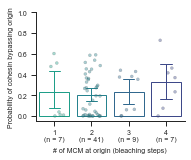

In [38]:
fig,axes = plt.subplots()
nacl_conc = '500 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.05,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
#get current xticklabels
labels = [label.get_text() for label in axes.get_xticklabels()]
#merge labels with nobs
for i in range(len(labels)):
    labels[i] = labels[i]+'\n('+nobs[i]+')'
axes.set_xticklabels(labels)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_500mM.svg',transparent=True)

### 4 - Pauses in cohesin translocation (150 mM data only)

### a - Cohesin translocation: fraction idle

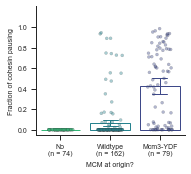

In [39]:
fig,axes = plt.subplots(figsize=([2.67, 2.36]))
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc)]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)
stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-0.05,1.2)
axes.set_yticks(np.arange(0,1.2,0.2))
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Fraction of cohesin pausing')


# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_150mM.svg',transparent=True)


### b - Cohesin translocation: fraction idle vs #MCM(wt)

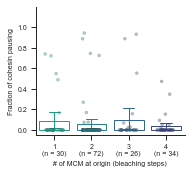

In [40]:
fig,axes = plt.subplots(figsize=([2.67, 2.36]))
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)



axes.set_ylim(-0.05,1.2)
axes.set_yticks(np.arange(0,1.2,0.2))
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Fraction of cohesin pausing')
axes.set_xticklabels(range(1,5))

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

#put nobs into plot together with xlabel
#get current xticklabels
labels = [label.get_text() for label in axes.get_xticklabels()]
#merge labels with nobs
for i in range(len(labels)):
    labels[i] = labels[i]+'\n('+nobs[i]+')'
axes.set_xticklabels(labels)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_vs#MCM_150mM.svg',transparent=True)

### c - Cohesin translocation: fraction idle vs #MCM(YDF)

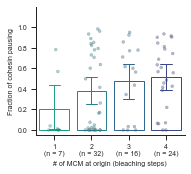

In [41]:
fig,axes = plt.subplots(figsize=([2.67, 2.36]))
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'ydf')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes, 
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)


axes.set_ylim(-0.05,1.2)
axes.set_yticks(np.arange(0,1.2,0.2))
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Fraction of cohesin pausing')
axes.set_xticklabels(range(1,5))

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

#put nobs into plot together with xlabel
#get current xticklabels
labels = [label.get_text() for label in axes.get_xticklabels()]
#merge labels with nobs
for i in range(len(labels)):
    labels[i] = labels[i]+'\n('+nobs[i]+')'
axes.set_xticklabels(labels)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_vs#MCM-YDF_150mM.svg',transparent=True)

### d - Cohesin translocation: Pause durations

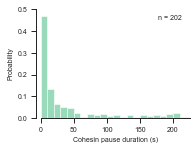

In [42]:
fig,axes = plt.subplots()

data = df_pause

sns.histplot(data['pause_duration'], bins=np.linspace(0,250,26), color=palette[2], stat='probability', alpha=0.5)

axes.set_xlim(0,225)
axes.set_ylim(0, 0.5)
axes.set_xlabel('Cohesin pause duration (s)')
axes.set_ylabel('Probability')
 
axes.text(0.95, 0.95, f"n = {len(data['pause_duration'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine(offset=dict(left=5))

plt.savefig(dir_out+'Cohesin_pause_durations.svg',transparent=True)

In [43]:
from scipy.optimize import curve_fit

In [44]:
data = df_pause[df_pause['pause_duration']>=10]['pause_duration']
X = np.linspace(10,220,211)
X

array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 16

In [45]:
y = [(data>x).sum().item() for x in X]
y = [num/y[0] for num in y]

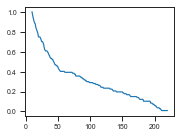

In [46]:
plt.plot(X, y)

In [47]:
def func(x, t):
    return 1-(0.5**(x/t))

In [48]:
pars, cov = curve_fit(func, X, y)

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))

# Calculate the residuals
res = y - func(X, *pars)

In [49]:
stdevs

array([56.26666709])

In [50]:
pars

array([414.71283974])

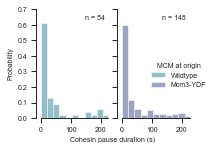

In [51]:
fig,axes = plt.subplots(1,2, sharey=True, sharex=True)

data = df_pause

sns.histplot(data[data['MCM_variant'] == 'wt']['pause_duration'], bins=np.linspace(0,250,13), color=palette[4], stat='probability', 
             alpha=0.5, ax=axes[0], label='Wildtype')

sns.histplot(data[data['MCM_variant'] == 'ydf']['pause_duration'], bins=np.linspace(0,250,13), color=palette[6], stat='probability', 
             alpha=0.5, ax=axes[1], label='Mcm3-YDF')
for ax in axes:
    ax.set_xlim(0,225)
    ax.set_ylim(0, 0.7)
    ax.set_xlabel(None)
    ax.set_ylabel('Probability')

axes[0].text(0.95, 0.95, f"n = {len(data[data['MCM_variant'] == 'wt'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes[0].transAxes)
axes[1].text(0.95, 0.95, f"n = {len(data[data['MCM_variant'] == 'ydf'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes[1].transAxes)

fig.text(0.5, -0.04, 'Cohesin pause duration (s)', ha='center')
fig.legend(frameon=False, loc=5, title='MCM at origin')

sns.despine(offset=dict(left=5))

plt.savefig(dir_out+'Cohesin_pause_durations_hue-MCMvariant.svg',transparent=True)

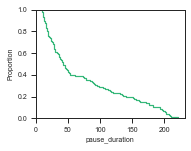

In [52]:
sns.ecdfplot(data[data['pause_duration']>=10]['pause_duration'], color=palette[2],complementary=True)

In [53]:
df_pause

,Cohesin_pause_pass,Cohesin_turnaround,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,NaN,False,True,3.0,3536.266783,wt,500 mM,False,52.69,20174.329127
0,False,NaN,True,2.0,5899.103012,wt,500 mM,True,6.46,6464.073379
0,False,True,True,2.0,5107.475979,wt,500 mM,True,3.45,4931.523516
0,False,False,True,2.0,5107.475979,wt,500 mM,True,182.28,4840.273699
0,False,True,True,2.0,5273.016721,wt,150 mM,True,35.80,4888.595960
...,...,...,...,...,...,...,...,...,...,...
0,True,False,True,4.0,14695.084469,ydf,150 mM,True,77.59,13827.637376
0,False,False,True,4.0,14695.084469,ydf,150 mM,True,35.69,14069.835421
0,False,False,True,4.0,14695.084469,ydf,150 mM,True,24.22,14223.325796
0,False,False,True,4.0,6610.954434,ydf,150 mM,True,9.10,7623.797709


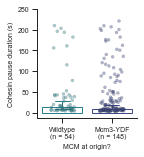

In [54]:
fig,axes = plt.subplots(figsize=(1.78,2))

data = df_pause

barprops = {'edgecolor': palette[4::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order':['wt','ydf']}

barplot_kwargs = dict(barprops, **kwargs)
stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='pause_duration', data=data, ax=axes,estimator=np.median,
            palette=palette[4::2], **barplot_kwargs)
sns.stripplot(x='MCM_variant', y='pause_duration', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[4::2], **stripplot_kwargs)


axes.set_ylim(-12.5,250)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Cohesin pause duration (s)')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'Wildtype\n({nobs[0]})', f'Mcm3-YDF\n({nobs[1]})'])
    
sns.despine()

plt.savefig(dir_out+'Cohesin_pause_durations_hueMCM.svg',transparent=True)

In [55]:
df_pause.groupby('MCM_variant')['pause_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
MCM_variant,,,,,,,,
wt,54.0,42.203907,60.068754,3.45,6.8750,14.690,42.40775,210.10
ydf,148.0,41.786959,57.641916,1.48,5.6975,9.605,50.50025,221.19


### e - Cohesin translocation: Pause position vs MCM position

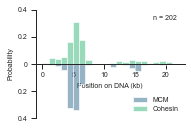

In [56]:
fig,axes = plt.subplots()

data = df_pause[df_pause['MCM_at_origin']]

sns.histplot(data['MCM_position_on_dna']/1000, bins=np.linspace(0,22,23), stat='probability',
             color=palette[5], label='MCM', alpha=0.5)

for p in axes.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in axes.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.histplot(data['pause_position_on_dna']/1000, bins=np.linspace(0,22,23), stat='probability',
             color=palette[2], label='Cohesin', alpha=0.5)

#axes.set_xlim(0,225)
axes.set_ylim(-0.4, 0.4)
axes.set_xlabel('Position on DNA (kb)')
axes.set_ylabel('Probability')
axes.legend(frameon=False, loc=4)
axes.set_yticks(np.arange(-0.4,0.5,0.2))
# pos_ticks = np.array([t for t in axes.get_yticks() if t > 0])
# ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
# axes.set_yticks(ticks)
axes.set_yticklabels([0.4, 0.2, 0, 0.2, 0.4])
axes.spines['bottom'].set_position('zero')

axes.text(0.95, 0.95, f"n = {len(data['pause_duration'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()

plt.savefig(dir_out+'Cohesin_pause_positions.svg',transparent=True)

### calculate collision outcome cohesin-MCM for each molecule

In [57]:
df2['ARS1 block (%)'] = 100*(df2['ARS1 block'] - df2[('Cohesin_1_','number_pauses')])/ df2['Visualized encounters']
df2['ARS1 pass (%)'] = 100*df2['ARS1 pass']/ df2['Visualized encounters']
df2['ARS1 pause (%)'] = 100*df2[('Cohesin_1_','number_pauses')] / df2['Visualized encounters']
df2

molecule               ARS1 block ARS1 pass          Cohesin_1_  \
properties                                  avg_position_on_dna   
2PFd8LrNDti9JB4QSh3mR9       51.0      30.0        10943.180951   
2QGskSzFLzrBr7YLN78knZ       80.0     153.0        11104.290270   
2Z4r51hJSvdkiVDjjqKUrj      113.0      55.0         6400.457100   
2sTgZedaFFf9CK5b3GF6Cn       14.0      24.0        13552.669057   
3AoBkpRczab2PADB4kryfY      131.0       4.0        11786.407599   
...                           ...       ...                 ...   
uD2qeX3fcDrkHLrEykKP3x       87.0      87.0        11812.807235   
uwCQQd5mMKFh5gQwnP9b3p      123.0     110.0        10979.640516   
vbQbfgRcaVUyxLdweJ2Y7p       39.0      25.0         9983.075330   
xcfK4nJ1oobZtYbMGVJHYQ      103.0      14.0        14092.327353   
xtREv4R9FAjgZ88vrbJPJM       65.0      61.0         9569.537131   

molecule                                                            \
properties             cum_pause_duration_(s)    d_coeff     dtime   
2PFd8LrNDti9JB4QSh3mR9                    0.0  19.546419  0.187930   
2QGskSzFLzrBr7YLN78knZ                    0.0  29.767491  0.182752   
2Z4r51hJSvdkiVDjjqKUrj                    0.0  43.310971  0.183297   
2sTgZedaFFf9CK5b3GF6Cn                    0.0  52.460617  0.184878   
3AoBkpRczab2PADB4kryfY                    0.0  23.531469  0.184084   
...                                       ...        ...       ...   
uD2qeX3fcDrkHLrEykKP3x                    0.0  19.707632  0.185782   
uwCQQd5mMKFh5gQwnP9b3p                    0.0  22.283112  0.186097   
vbQbfgRcaVUyxLdweJ2Y7p                    0.0  11.486890  0.185274   
xcfK4nJ1oobZtYbMGVJHYQ                    0.0   3.351588  0.185053   
xtREv4R9FAjgZ88vrbJPJM                    0.0  18.089110  0.186255   

molecule                                                                    \
properties             fraction_idle initial_intensity lifetime        msd   
2PFd8LrNDti9JB4QSh3mR9           0.0           86644.6      NaN   7.346713   
2QGskSzFLzrBr7YLN78knZ           0.0           29989.5      NaN  10.880131   
2Z4r51hJSvdkiVDjjqKUrj           0.0           19703.6      NaN  15.877540   
2sTgZedaFFf9CK5b3GF6Cn           0.0            9802.7      NaN  19.397633   
3AoBkpRczab2PADB4kryfY           0.0           33791.1      NaN   8.663536   
...                              ...               ...      ...        ...   
uD2qeX3fcDrkHLrEykKP3x           0.0           24928.3      NaN   7.322659   
uwCQQd5mMKFh5gQwnP9b3p           0.0           42789.6      NaN   8.293621   
vbQbfgRcaVUyxLdweJ2Y7p           0.0           11532.8      NaN   4.256441   
xcfK4nJ1oobZtYbMGVJHYQ           0.0           12821.3      NaN   1.240442   
xtREv4R9FAjgZ88vrbJPJM           0.0           23820.3      NaN   6.738368   

molecule                ...   label_MCM    nacl nucleotide number_Cohesin  \
properties              ...                                                 
2PFd8LrNDti9JB4QSh3mR9  ...  ybbR-LD655  500 mM        ATP            1.0   
2QGskSzFLzrBr7YLN78knZ  ...  ybbR-LD655  500 mM        ATP            1.0   
2Z4r51hJSvdkiVDjjqKUrj  ...  ybbR-LD655  500 mM        ATP            1.0   
2sTgZedaFFf9CK5b3GF6Cn  ...  ybbR-LD655  500 mM        ATP            1.0   
3AoBkpRczab2PADB4kryfY  ...  ybbR-LD655  500 mM        ATP            1.0   
...                     ...         ...     ...        ...            ...   
uD2qeX3fcDrkHLrEykKP3x  ...         NaN  150 mM        ATP            1.0   
uwCQQd5mMKFh5gQwnP9b3p  ...         NaN  150 mM        ATP            1.0   
vbQbfgRcaVUyxLdweJ2Y7p  ...         NaN  150 mM        ATP            1.0   
xcfK4nJ1oobZtYbMGVJHYQ  ...         NaN  150 mM        ATP            1.0   
xtREv4R9FAjgZ88vrbJPJM  ...         NaN  150 mM        ATP            1.0   

molecule               number_MCM               tags ARS1 passing probability  \
properties                                                                      
2PFd8LrNDti9JB4QSh3mR9        1.0     

In [58]:
_plot_df = pd.DataFrame()
for column in ['ARS1 pass (%)', 'ARS1 block (%)', 'ARS1 pause (%)']:
    _temp_df = pd.DataFrame()
    _temp_df['probability'] = df2[column]
    _temp_df['outcome'] = column
    _temp_df['MCM_variant'] = df2['MCM_variant']
    _temp_df['nacl'] = df2['nacl']
    
    _plot_df = pd.concat([_plot_df, _temp_df])

_plot_df

,probability,outcome,MCM_variant,nacl
2PFd8LrNDti9JB4QSh3mR9,37.037037,ARS1 pass (%),wt,500 mM
2QGskSzFLzrBr7YLN78knZ,65.665236,ARS1 pass (%),n/a,500 mM
2Z4r51hJSvdkiVDjjqKUrj,32.738095,ARS1 pass (%),wt,500 mM
2sTgZedaFFf9CK5b3GF6Cn,63.157895,ARS1 pass (%),n/a,500 mM
3AoBkpRczab2PADB4kryfY,2.962963,ARS1 pass (%),wt,500 mM
...,...,...,...,...
uD2qeX3fcDrkHLrEykKP3x,0.000000,ARS1 pause (%),n/a,150 mM
uwCQQd5mMKFh5gQwnP9b3p,0.000000,ARS1 pause (%),n/a,150 mM
vbQbfgRcaVUyxLdweJ2Y7p,0.000000,ARS1 pause (%),n/a,150 mM
xcfK4nJ1oobZtYbMGVJHYQ,0.000000,ARS1 pause (%),n/a,150 mM


In [59]:
_plot_df.groupby(['nacl','outcome','MCM_variant']).describe()

probability                        \
                                        count       mean        std   
nacl   outcome        MCM_variant                                     
150 mM ARS1 block (%) n/a                74.0  63.084513  14.490065   
                      wt                162.0  89.040317  16.435189   
                      ydf                79.0  88.065782  19.423590   
       ARS1 pass (%)  n/a                74.0  36.915487  14.490065   
                      wt                162.0   9.001305  12.855503   
                      ydf                79.0   5.624382   8.171849   
       ARS1 pause (%) n/a                74.0   0.000000   0.000000   
                      wt                162.0   1.958378  11.265304   
                      ydf                79.0   6.309836  19.014174   
500 mM ARS1 block (%) n/a                40.0  42.502285  14.380666   
                      wt                 64.0  77.306419  21.239216   
       ARS1 pass (%)  n/a                40.0  57.497715  14.380666   
                      wt                 64.0  22.595108  21.148456   
       ARS1 pause (%) n/a                40.0   0.000000   0.000000   
                      wt                 64.0   0.098473   0.678924   

                                                                    \
                                         min        25%        50%   
nacl   outcome        MCM_variant                                    
150 mM ARS1 block (%) n/a          33.333333  51.887901  62.236737   
                      wt            0.000000  83.333333  95.238095   
                      ydf           0.000000  87.952899  93.518519   
       ARS1 pass (%)  n/a           0.000000  28.613611  37.763263   
                      wt            0.000000   0.000000   2.670940   
                      ydf           0.000000   0.000000   2.996255   
       ARS1 pause (%) n/a           0.000000   0.000000   0.000000   
                      wt            0.000000   0.000000   0.000000   
                      ydf           0.000000   0.337546   1.769912   
500 mM ARS1 block (%) n/a          19.847328  34.308120  38.379996   
                      wt           26.940639  58.049611  78.558897   
       ARS1 pass (%)  n/a          12.707182  56.306476  61.620004   
                      wt            0.000000   1.137637  21.441103   
       ARS1 pause (%) n/a           0.000000   0.000000   0.000000   
                      wt            0.000000   0.000000   0.000000   

                                                           
                                          75%         max  
nacl   outcome        MCM_variant                          
150 mM ARS1 block (%) n/a           71.386389  100.000000  
                      wt           100.000000  100.000000  
                      ydf           96.604859  100.000000  
       ARS1 pass (%)  n/a           48.112099   66.666667  
                      wt            15.635522   68.181818  
                      ydf            8.648901   50.450450  
       ARS1 pause (%) n/a            0.000000    0.000000  
                      wt             0.000000  100.000000  
                      ydf            3.637566  100.000000  
500 mM ARS1 block (%) n/a           43.693524   87.292818  
                      wt            98.862363  100.000000  
       ARS1 pass (%)  n/a           65.691880   80.152672  
                      wt            40.822072   73.059361  
       ARS1 pause (%) n/a            0.000000    0.000000  
                      wt             0.000000    5.405405

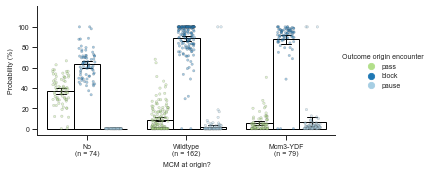

In [60]:
fig,axes = plt.subplots(figsize=(5.34, 2.36))
data = _plot_df[_plot_df['nacl']=='150 mM']

barprops = {'edgecolor': 'k','linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf'], 'hue_order': ['ARS1 pass (%)', 'ARS1 block (%)', 'ARS1 pause (%)']}

barplot_kwargs = dict(barprops, **kwargs)
stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2.5, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='probability', hue='outcome', data=data, ax=axes,
            palette=palette_qual, **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='probability', hue='outcome', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette_qual, **stripplot_kwargs)

axes.set_ylim(-6,120)
axes.set_yticks(np.arange(0,120,20))
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability (%)')


# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = df2[df2['nacl']=='150 mM'].groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})', f'Mcm3-YDF\n({nobs[2]})'])

# Fix the legend, keep only the first two legend elements
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles[:3], ['pass', 'block', 'pause'], frameon=False, title='Outcome origin encounter',
               loc='center left', bbox_to_anchor=[1, 0.5],handletextpad=0.5)

lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]
lgd.legendHandles[2]._sizes = [40]
    
sns.despine()

plt.savefig(dir_out+'Cohesin_MCM_encounter_outcomes.svg',transparent=True)

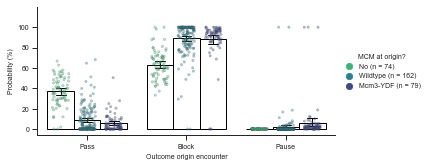

In [61]:
fig,axes = plt.subplots(figsize=(5.34, 2.36))
data = _plot_df[_plot_df['nacl']=='150 mM']

barprops = {'edgecolor': 'k','linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.1, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'hue_order': ['n/a', 'wt', 'ydf'], 'order': ['ARS1 pass (%)', 'ARS1 block (%)', 'ARS1 pause (%)']}

barplot_kwargs = dict(barprops, **kwargs)
stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2.5, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='outcome', y='probability', hue='MCM_variant', data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='outcome', y='probability', hue='MCM_variant', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_ylim(-6,120)
axes.set_yticks(np.arange(0,120,20))
axes.set_xlabel('Outcome origin encounter')
axes.set_ylabel('Probability (%)')


# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = df2[df2['nacl']=='150 mM'].groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels(['Pass', 'Block', 'Pause'])

# Fix the legend, keep only the first two legend elements
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles[:3], [f'No ({nobs[0]})', f'Wildtype ({nobs[1]})', f'Mcm3-YDF ({nobs[2]})'], frameon=False, title='MCM at origin?',
               loc='center left', bbox_to_anchor=[1, 0.5],handletextpad=0.5)

lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]
lgd.legendHandles[2]._sizes = [40]


sns.despine()

plt.savefig(dir_out+'Cohesin_MCM_encounter_outcomes_v2.svg',transparent=True)

In [62]:
df_pause

,Cohesin_pause_pass,Cohesin_turnaround,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,NaN,False,True,3.0,3536.266783,wt,500 mM,False,52.69,20174.329127
0,False,NaN,True,2.0,5899.103012,wt,500 mM,True,6.46,6464.073379
0,False,True,True,2.0,5107.475979,wt,500 mM,True,3.45,4931.523516
0,False,False,True,2.0,5107.475979,wt,500 mM,True,182.28,4840.273699
0,False,True,True,2.0,5273.016721,wt,150 mM,True,35.80,4888.595960
...,...,...,...,...,...,...,...,...,...,...
0,True,False,True,4.0,14695.084469,ydf,150 mM,True,77.59,13827.637376
0,False,False,True,4.0,14695.084469,ydf,150 mM,True,35.69,14069.835421
0,False,False,True,4.0,14695.084469,ydf,150 mM,True,24.22,14223.325796
0,False,False,True,4.0,6610.954434,ydf,150 mM,True,9.10,7623.797709


### Cohesin direction after pause

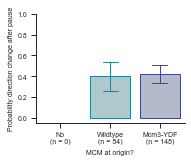

In [63]:
fig,axes = plt.subplots()

data = df_pause

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order':['n/a','wt','ydf']}

barplot_kwargs = dict(barprops, **kwargs)


sns.barplot(x='MCM_variant', y='Cohesin_turnaround', data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability direction change after pause')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n(n = 0)', f'Wildtype\n({nobs[0]})', f'Mcm3-YDF\n({nobs[1]})'])
    
sns.despine()

plt.savefig(dir_out+'Cohesin_pause_turnaround.svg',transparent=True)

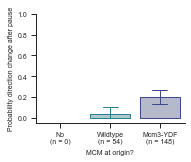

In [64]:
fig,axes = plt.subplots()

data = df_pause

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order':['n/a','wt','ydf']}

barplot_kwargs = dict(barprops, **kwargs)


sns.barplot(x='MCM_variant', y='Cohesin_pause_pass', data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability direction change after pause')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n(n = 0)', f'Wildtype\n({nobs[0]})', f'Mcm3-YDF\n({nobs[1]})'])
    
sns.despine()

plt.savefig(dir_out+'Cohesin_pause_bypass.svg',transparent=True)


# QUESTIONS FOR KARL

Statistics:
- Tests: Welch t-test / Welch ANOVA for everything? although sometimes variances are equal, sample size is not. some suggest Welch as default
- for ttests I tested for equal variance so far and gave that as input
- 3 groups: should we do ANOVA and posthoc gameshowell?

Others:
- I added 1 encounter and 1 block for each pause now, independent of MCM colocalization (what would be the cutoff etc).
- reported blocking: pauses excluded, each pause calculated +1 block for now

In [65]:
# Actual numbers of encounters (for figure legend)

In [66]:
df2.groupby(['nacl','MCM_variant'])['Visualized encounters'].sum()

nacl    MCM_variant
150 mM  n/a            12175.0
        wt             15348.0
        ydf             9455.0
500 mM  n/a             7802.0
        wt              9829.0
Name: Visualized encounters, dtype: float64

In [67]:
df2.groupby(['nacl','MCM_variant'])['ARS1 pass'].sum()

nacl    MCM_variant
150 mM  n/a            4571.0
        wt             1448.0
        ydf             722.0
500 mM  n/a            4557.0
        wt             2231.0
Name: ARS1 pass, dtype: float64

In [68]:
df2.groupby(['nacl','MCM_variant'])['ARS1 block'].sum()

nacl    MCM_variant
150 mM  n/a             7604.0
        wt             13900.0
        ydf             8733.0
500 mM  n/a             3245.0
        wt              7598.0
Name: ARS1 block, dtype: float64

In [69]:
df2.groupby(['nacl','MCM_variant'])['ARS1 passing probability'].describe()

count      mean       std       min       25%       50%  \
nacl   MCM_variant                                                            
150 mM n/a           74.0  0.369155  0.144901  0.000000  0.286136  0.377633   
       wt           162.0  0.090013  0.128555  0.000000  0.000000  0.026709   
       ydf           79.0  0.056244  0.081718  0.000000  0.000000  0.029963   
500 mM n/a           40.0  0.574977  0.143807  0.127072  0.563065  0.616200   
       wt            64.0  0.225951  0.211485  0.000000  0.011376  0.214411   

                         75%       max  
nacl   MCM_variant                      
150 mM n/a          0.481121  0.666667  
       wt           0.156355  0.681818  
       ydf          0.086489  0.504505  
500 mM n/a          0.656919  0.801527  
       wt           0.408221  0.730594

In [70]:
# strong barrier = 5 fold reduction in passing probability compared to cohesin alone
# => 500 mM NaCl: 0.115
# => 150 mM NaCl: 0.074

In [71]:
df2[df2['ARS1 passing probability'] < 0.115].groupby(['nacl','MCM_variant'])['ARS1 passing probability'].describe()

count      mean       std  min  25%       50%       75%  \
nacl   MCM_variant                                                            
150 mM n/a            4.0  0.032789  0.053636  0.0  0.0  0.009524  0.042313   
       wt           113.0  0.021448  0.034062  0.0  0.0  0.000000  0.034483   
       ydf           67.0  0.029325  0.033548  0.0  0.0  0.017857  0.047516   
500 mM wt            29.0  0.021704  0.030590  0.0  0.0  0.005556  0.038781   

                         max  
nacl   MCM_variant            
150 mM n/a          0.112108  
       wt           0.111111  
       ydf          0.113402  
500 mM wt           0.114558

In [72]:
df2[df2['ARS1 passing probability'] < 0.074].groupby(['nacl','MCM_variant'])['ARS1 passing probability'].describe()

count      mean       std  min  25%       50%       75%  \
nacl   MCM_variant                                                            
150 mM n/a            3.0  0.006349  0.010997  0.0  0.0  0.000000  0.009524   
       wt            97.0  0.009460  0.017397  0.0  0.0  0.000000  0.012987   
       ydf           58.0  0.018667  0.020659  0.0  0.0  0.012461  0.035169   
500 mM wt            27.0  0.016314  0.023221  0.0  0.0  0.004762  0.022061   

                         max  
nacl   MCM_variant            
150 mM n/a          0.019048  
       wt           0.067797  
       ydf          0.059701  
500 mM wt           0.069930

In [73]:
df2[df2['ARS1 passing probability'] == 0].groupby(['nacl','MCM_variant'])['ARS1 passing probability'].describe()

count  mean  std  min  25%  50%  75%  max
nacl   MCM_variant                                           
150 mM n/a            2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
       wt            67.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
       ydf           25.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
500 mM wt            12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [74]:
df2.groupby(['nacl','MCM_variant']).describe()[('Cohesin_1_','fraction_idle')]

count      mean       std  min       25%      50%  \
nacl   MCM_variant                                                      
150 mM n/a           74.0  0.000000  0.000000  0.0  0.000000  0.00000   
       wt           162.0  0.064347  0.196866  0.0  0.000000  0.00000   
       ydf           79.0  0.427782  0.360965  0.0  0.021972  0.45816   
500 mM n/a           40.0  0.000000  0.000000  0.0  0.000000  0.00000   
       wt            64.0  0.017811  0.110930  0.0  0.000000  0.00000   

                        75%       max  
nacl   MCM_variant                     
150 mM n/a          0.00000  0.000000  
       wt           0.00000  0.944482  
       ydf          0.77995  0.984467  
500 mM n/a          0.00000  0.000000  
       wt           0.00000  0.854006

In [75]:
df2.groupby(['nacl','MCM_variant','MCM_bleaching_steps']).describe()[('Cohesin_1_','fraction_idle')]

count      mean       std  min  \
nacl   MCM_variant MCM_bleaching_steps                                   
150 mM wt          1.0                   30.0  0.089064  0.220143  0.0   
                   2.0                   72.0  0.054130  0.193907  0.0   
                   3.0                   26.0  0.102243  0.263085  0.0   
                   4.0                   34.0  0.035195  0.101854  0.0   
       ydf         1.0                    7.0  0.200683  0.331342  0.0   
                   2.0                   32.0  0.382825  0.385218  0.0   
                   3.0                   16.0  0.476917  0.359749  0.0   
                   4.0                   24.0  0.521207  0.315475  0.0   
500 mM wt          1.0                    7.0  0.000000  0.000000  0.0   
                   2.0                   41.0  0.021569  0.133339  0.0   
                   3.0                    9.0  0.028392  0.085176  0.0   
                   4.0                    7.0  0.000000  0.000000  0.0   

                                             25%       50%       75%       max  
nacl   MCM_variant MCM_bleaching_steps                                          
150 mM wt          1.0                  0.000000  0.000000  0.000000  0.741193  
                   2.0                  0.000000  0.000000  0.000000  0.944482  
                   3.0                  0.000000  0.000000  0.015942  0.933728  
                   4.0                  0.000000  0.000000  0.000000  0.473463  
       ydf         1.0                  0.000000  0.011260  0.304944  0.783631  
                   2.0                  0.000000  0.217018  0.784665  0.984467  
                   3.0                  0.033927  0.582993  0.773942  0.951209  
                   4.0                  0.345489  0.563323  0.795002  0.936512  
500 mM wt          1.0                  0.000000  0.000000  0.000000  0.000000  
                   2.0                  0.000000  0.000000  0.000000  0.854006  
                   3.0                  0.000000  0.000000  0.000000  0.255529  
                   4.0                  0.000000  0.000000  0.000000  0.000000

In [76]:
df2.groupby(['nacl','MCM_variant','MCM_bleaching_steps']).describe()['ARS1 passing probability']

properties                                                             \
                                       count      mean       std  min   
nacl   MCM_variant MCM_bleaching_steps                                  
150 mM wt          1.0                  30.0  0.054668  0.106008  0.0   
                   2.0                  72.0  0.081868  0.099971  0.0   
                   3.0                  26.0  0.153226  0.206195  0.0   
                   4.0                  34.0  0.090109  0.112305  0.0   
       ydf         1.0                   7.0  0.078628  0.114763  0.0   
                   2.0                  32.0  0.058362  0.070686  0.0   
                   3.0                  16.0  0.057940  0.045978  0.0   
                   4.0                  24.0  0.045760  0.104031  0.0   
500 mM wt          1.0                   7.0  0.235952  0.278423  0.0   
                   2.0                  41.0  0.205207  0.199157  0.0   
                   3.0                   9.0  0.234221  0.195333  0.0   
                   4.0                   7.0  0.326816  0.248546  0.0   

properties                                                                      
                                             25%       50%       75%       max  
nacl   MCM_variant MCM_bleaching_steps                                          
150 mM wt          1.0                  0.000000  0.000000  0.087956  0.512195  
                   2.0                  0.000000  0.028595  0.151852  0.398230  
                   3.0                  0.000000  0.043810  0.238453  0.681818  
                   4.0                  0.000000  0.029045  0.165404  0.410000  
       ydf         1.0                  0.000000  0.013158  0.129732  0.277778  
                   2.0                  0.009120  0.027382  0.098538  0.250000  
                   3.0                  0.021549  0.048967  0.091358  0.153846  
                   4.0                  0.000000  0.000000  0.043750  0.504505  
500 mM wt          1.0                  0.010483  0.038781  0.494556  0.602804  
                   2.0                  0.005556  0.193237  0.361991  0.590476  
                   3.0                  0.060109  0.353933  0.381818  0.441176  
                   4.0                  0.153857  0.370370  0.439516  0.730594

In [ ]:
# changing to violin

0
1
2
3
4
5


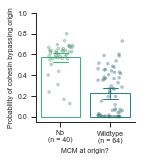

In [93]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 1.5)
axes.set_ylim(-0.05,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    print(i)
    if i ==0:
        line.remove()
    else:
        newcolor = patches[i // lines_per_err].get_edgecolor()
        line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot together with xlabel
axes.set_xticklabels([f'No\n({nobs[0]})', f'Wildtype\n({nobs[1]})'])
    
sns.despine()

#plt.savefig(dir_out+'Cohesin_origin_bypass_500mM.svg',transparent=True)

In [88]:
axes.get

<a list of 6 Line2D objects>

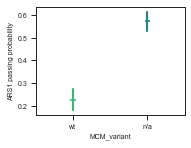

In [103]:
sns.pointplot(x='MCM_variant', y='ARS1 passing probability',data=data,
            palette=palette[2::2], markers='_',markerwidth=20)

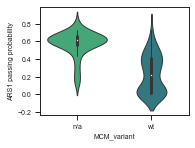

In [159]:
sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, 
            palette=palette[2::2], **barplot_kwargs)


In [168]:
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]
kwargs = {'order': ['n/a', 'wt', 'ydf']}
barplot_kwargs = dict(barprops, **kwargs)

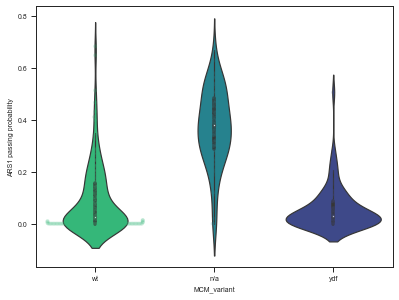

In [199]:
fig, axes = plt.subplots(figsize=(19,4.8))
sns.violinplot(x='MCM_variant', y='ARS1 passing probability',data=data, 
            palette=palette[2::2], saturation=1, **dict(alpha=0.2), ax=axes)
sns.swarmplot(x='MCM_variant', y='ARS1 passing probability',data=data, 
            palette=palette[2::2], size=4, ax=axes, alpha=0.2)
fig.set_size_inches(6.4,4.8)

## OFF TOPIC: Wordcloud for my PhD thesis :D

In [ ]:
# Libraries
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import string
import docx2txt

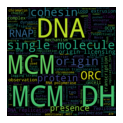

In [148]:
# Create a list of word

my_diss = docx2txt.process("/Users/matze/Documents/PhD/_THESIS/Documents/PhD_thesis_Scherr_Sep17.docx")

# Create the wordcloud object
wordcloud = WordCloud(width=960, height=960, margin=0).generate(my_diss)

stop_words = ["Figure", "et", "al"] + list(STOPWORDS) + list(string.ascii_letters)
wordcloud = WordCloud(width=1500, height=1500, margin=0, stopwords = stop_words, background_color="black",random_state=87).generate(my_diss)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('/Users/matze/Documents/PhD/_THESIS/Documents/wordcloud.png')

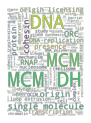

In [157]:
# Create a list of word

my_diss = docx2txt.process("/Users/matze/Documents/PhD/_THESIS/Documents/PhD_thesis_Scherr_Sep17.docx")

# Create the wordcloud object

stop_words = ["Figure", "et", "al"] + list(STOPWORDS) + list(string.ascii_letters)
wordcloud = WordCloud(width=int(1500*210/297), height=1500, margin=0, stopwords = stop_words, mode = "RGBA", background_color=None,random_state=87).generate(my_diss)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('/Users/matze/Documents/PhD/_THESIS/Documents/wordcloud_white.png')